In [ ]:
import warnings

# Option 1: Ignore all FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)

print("FutureWarnings are now ignored.")

FutureWarnings are now ignored.


In [ ]:
# Mount Google Drive
import os
from google.colab import drive
import pandas as pd
import numpy as np
from scipy.stats import zscore # For calculating Z-scores

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- READ THE CLIENT CSV FILE ---

# Specify the base directory where your data files are located in Google Drive
data_dir = '/content/drive/MyDrive/HIV-Exp-Project/Data'

# Define the full path to the CSV file you want to read
csv_filename = 'balanced_data.csv'
file_path_to_read = os.path.join(data_dir, csv_filename)

# Read the data from the specified CSV file
df = pd.read_csv(file_path_to_read)

print("\nFirst 5 rows of df:")
df.head()


First 5 rows of df:


,EnumID,State,Age,Gender,Marital Status,Family Setting,Num of Children,Educational Status,Employment Status,Monthly Income,...,Meds_Explained_SideFX,Encourage_Questions,Respond_Q_Concerns,Showed_Personal_Concern,Involved_In_Decisions,Discuss_NextSteps,Checked_Understanding,Time_Spent_Adequate,Visit_Satisfaction,Source
0,SYNTH-NEU-284,Jigawa,25-34,Female,Married,Monogamy,1-2,"Tertiary education (e.g., University, college)",Self-employed,"Less than 20,000 Naira",...,Agree,Agree,Neither Agree or Disagree,Strongly Agree,Agree,Agree,Agree,Agree,Neutral,Synthetic
1,BC023,Bauchi,25-34,Female,Widowed,Polygamy,Greater than 4,No formal education,Self-employed,"Less than 20,000 Naira",...,Strongly Agree,Strongly Agree,Agree,Disagree,Agree,Agree,Disagree,Agree,Very satisfied,Original
2,SYNTH-SAT-140,Jigawa,55 years and above,Female,Widowed,Monogamy,1-2,Secondary education,Unemployed,"51,000–100,000 Naira",...,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Disagree,Satisfied,Synthetic
3,JG14,Jigawa,35–44,Female,Divorced,Monogamy,1-2,Secondary education,Employed part-time,"Less than 20,000 Naira",...,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Very satisfied,Original
4,SYNTH-VER-519,Bauchi,35–44,Female,Single,Monogamy,Greater than 4,Secondary education,Self-employed,"Less than 20,000 Naira",...,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Very dissatisfied,Synthetic


## Data Preprocessing

In [ ]:
#@title Combine Target Labels

# Combine 'Neutral' and 'Very dissatisfied' into 'Not satisfied'
df['Visit_Satisfaction'] = df['Visit_Satisfaction'].replace(
    ['Neutral', 'Very dissatisfied'],
    'Not satisfied'
)

df['Visit_Satisfaction'].value_counts()

,count
Visit_Satisfaction,
Very satisfied,375
Not satisfied,345
Satisfied,326


### Transformation of Continuous Variables (Currently Categorical Ranges)

In [ ]:
#@title 1. Transform 'Age'
age_mapping = {
    '18–24': 21,
    '25-34': 29.5,
    '35–44': 39.5,
    '45–54': 49.5,
    '55 years and above': 65 # Estimating 65 as a reasonable midpoint for an open-ended "above 55"
}
df['Age'] = df['Age'].replace(age_mapping).astype(float) # Convert to float

print("--- Transformed 'Age' ---")
print(df['Age'].unique())
print(df[['Age']].head())
print("-" * 30)

--- Transformed 'Age' ---
[29.5 65.  39.5 21.  49.5]
    Age
0  29.5
1  29.5
2  65.0
3  39.5
4  39.5
------------------------------


In [ ]:
#@title 2. Transform 'Num of Children'

children_mapping = {
    '1-2': 1.5,
    '3-4': 3.5,
    'Greater than 4': 5 # Estimating 5 as a reasonable value for "Greater than 4"
}
df['Num of Children'] = df['Num of Children'].replace(children_mapping).astype(float)

print("--- Transformed 'Num of Children' ---")
print(df['Num of Children'].unique())
print(df[['Num of Children']].head())
print("-" * 30)

--- Transformed 'Num of Children' ---
[1.5 5.  3.5]
   Num of Children
0              1.5
1              5.0
2              1.5
3              1.5
4              5.0
------------------------------


In [ ]:
#@title 3. Transform 'Monthly Income'
income_mapping = {
    'Less than 20,000 Naira': 10000,
    '20,000–50,000 Naira': 35000,
    '51,000–100,000 Naira': 75500,
    '101,000–200,000 Naira': 150500,
    'More than 200,000 Naira': 250000, # Estimating 250,000 as a reasonable value
    'Prefer not to say': np.nan # Map 'Prefer not to say' to NaN
}
df['Monthly Income'] = df['Monthly Income'].replace(income_mapping).astype(float)

print("--- Transformed 'Monthly Income' ---")
print(df['Monthly Income'].unique())
print(df[['Monthly Income']].head())
print("-" * 30)

--- Transformed 'Monthly Income' ---
[ 10000.  75500.  35000.     nan 150500. 250000.]
   Monthly Income
0         10000.0
1         10000.0
2         75500.0
3         10000.0
4         10000.0
------------------------------


In [ ]:
#@title 4. Transform Duration Columns (HIV_Duration_Years, Care_Duration_Years, Facility_Care_Dur_Years)
# Note: Pay attention to different hyphens (en-dash vs. hyphen)
duration_mapping = {
    'Less than 1 year': 0.5,
    '1-3 years': 2,
    '1–3 years': 2, # Handle en-dash variation
    '4-7 years': 5.5,
    '4–7 years': 5.5, # Handle en-dash variation
    '8-10 years': 9,
    '8–10 years': 9, # Handle en-dash variation
    'More than 10 years': 12.5 # Estimating 12.5 as a reasonable value
}

for col in ['HIV_Duration_Years', 'Care_Duration_Years', 'Facility_Care_Dur_Years']:
    df[col] = df[col].replace(duration_mapping).astype(float)
    print(f"--- Transformed '{col}' ---")
    print(df[col].unique())
    print(df[[col]].head())
    print("-" * 30)

#print("\n--- Final DataFrame head with transformed numerical columns ---")
#print(df.head())
print("\nDataFrame Info (check dtypes):")
df.info()

--- Transformed 'HIV_Duration_Years' ---
[ 2.  12.5  9.   0.5  5.5]
   HIV_Duration_Years
0                 2.0
1                12.5
2                 2.0
3                12.5
4                 9.0
------------------------------
--- Transformed 'Care_Duration_Years' ---
[12.5  0.5  2.   9.   5.5]
   Care_Duration_Years
0                 12.5
1                  0.5
2                  2.0
3                 12.5
4                  9.0
------------------------------
--- Transformed 'Facility_Care_Dur_Years' ---
[ 2.   0.5  9.  12.5  5.5]
   Facility_Care_Dur_Years
0                      2.0
1                      0.5
2                      9.0
3                     12.5
4                      9.0
------------------------------

DataFrame Info (check dtypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EnumID     

In [ ]:
#@title Fill the missing data points in Monthly Income with Imputation with a Missing Indicator (using Median)
# Create the missing indicator column
df['Monthly_Income_Missing'] = df['Monthly Income'].isna().astype(int)

# Then, fill the NaNs in the original column using median imputation
median_income = df['Monthly Income'].median()
df['Monthly Income'].fillna(median_income, inplace=True)

print("Monthly Income after imputation and adding missing indicator:")
print(df[['Monthly Income', 'Monthly_Income_Missing']].head(10))
print("\nValue counts for Monthly_Income_Missing:")
print(df['Monthly_Income_Missing'].value_counts())

Monthly Income after imputation and adding missing indicator:
   Monthly Income  Monthly_Income_Missing
0         10000.0                       0
1         10000.0                       0
2         75500.0                       0
3         10000.0                       0
4         10000.0                       0
5         75500.0                       0
6         10000.0                       0
7         10000.0                       0
8         75500.0                       0
9         10000.0                       0

Value counts for Monthly_Income_Missing:
Monthly_Income_Missing
0    893
1    153
Name: count, dtype: int64


## B. Dealing with Outliers

In [ ]:
#@title Identify outlier with Z-score and treat the identified outlier with Log Transformation

# List of continuous numerical columns to process
continuous_cols = [
    'Age',
    'Num of Children',
    'Monthly Income',
    'HIV_Duration_Years',
    'Care_Duration_Years',
    'Facility_Care_Dur_Years'
]

# --- Outlier Identification using Z-score ---
print("--- Outlier Identification (Z-score) ---")
# This step helps you identify data points that are statistically far from the mean.
# We are creating new Z-score columns; not modifying the original values yet.
for col in continuous_cols:
    df[f'{col}_zscore'] = np.abs(zscore(df[col]))
    # Filter to show potential outliers (e.g., |Z-score| > 3 standard deviations)
    outliers = df[df[f'{col}_zscore'] > 3]
    print(f"Column: '{col}'")
    if not outliers.empty:
        print(f"  {len(outliers)} potential outlier(s) with |Z-score| > 3:")
        print(outliers[[col, f'{col}_zscore']])
    else:
        print(f"  No potential outliers found with |Z-score| > 3 for '{col}'.")
    print("-" * 30)

# --- Outlier Treatment with Log Transformation ---
print("\n--- Applying Log Transformation (np.log1p) ---")
# This transformation helps reduce skewness and compress the range of values,
# thereby mitigating the influence of extreme values (outliers).
for col in continuous_cols:
    # Create a new column for the log-transformed data
    # np.log1p(x) computes log(x+1), which handles potential zeros gracefully.
    df[f'{col}_log'] = np.log1p(df[col])
    print(f"'{col}' transformed to '{col}_log'.")

print("\n--- Final DataFrame head with transformed (and potentially log-transformed) columns ---")
# Display original numerical, their Z-scores, and log-transformed columns side-by-side
display_cols = []
for col in continuous_cols:
    display_cols.extend([col, f'{col}_zscore', f'{col}_log'])
print(df[display_cols].head())

print("\nDataFrame Info (check dtypes and new columns):")
df.info()

--- Outlier Identification (Z-score) ---
Column: 'Age'
  No potential outliers found with |Z-score| > 3 for 'Age'.
------------------------------
Column: 'Num of Children'
  No potential outliers found with |Z-score| > 3 for 'Num of Children'.
------------------------------
Column: 'Monthly Income'
  9 potential outlier(s) with |Z-score| > 3:
     Monthly Income  Monthly Income_zscore
77         250000.0               4.945044
112        250000.0               4.945044
253        250000.0               4.945044
305        250000.0               4.945044
396        250000.0               4.945044
554        250000.0               4.945044
730        250000.0               4.945044
909        250000.0               4.945044
968        250000.0               4.945044
------------------------------
Column: 'HIV_Duration_Years'
  No potential outliers found with |Z-score| > 3 for 'HIV_Duration_Years'.
------------------------------
Column: 'Care_Duration_Years'
  No potential outliers found

## Standardize Likert-Scale Responses

In [ ]:
df.columns

Index(['EnumID', 'State', 'Age', 'Gender', 'Marital Status', 'Family Setting',
       'Num of Children', 'Educational Status', 'Employment Status',
       'Monthly Income', 'Treatment Regimen', 'HIV_Duration_Years',
       'Care_Duration_Years', 'Facility_Care_Dur_Years', 'HIV_Diag_Type',
       'Greet_Comfort', 'Discuss_VisitReason', 'Encourage_Thoughts',
       'Listen_Careful', 'Understood_You', 'Exam_Explained',
       'LabTests_Explained', 'Discuss_TreatOptions', 'Info_AsDesired',
       'Plan_Acceptability_Check', 'Meds_Explained_SideFX',
       'Encourage_Questions', 'Respond_Q_Concerns', 'Showed_Personal_Concern',
       'Involved_In_Decisions', 'Discuss_NextSteps', 'Checked_Understanding',
       'Time_Spent_Adequate', 'Visit_Satisfaction', 'Source',
       'Monthly_Income_Missing', 'Age_zscore', 'Num of Children_zscore',
       'Monthly Income_zscore', 'HIV_Duration_Years_zscore',
       'Care_Duration_Years_zscore', 'Facility_Care_Dur_Years_zscore',
       'Age_log', 'Num of

In [ ]:
#@title Define Likert columns (can adjust if needed)
likert_columns = [
       'Greet_Comfort', 'Discuss_VisitReason', 'Encourage_Thoughts',
       'Listen_Careful', 'Understood_You', 'Exam_Explained',
       'LabTests_Explained', 'Discuss_TreatOptions', 'Info_AsDesired',
       'Plan_Acceptability_Check', 'Meds_Explained_SideFX',
       'Encourage_Questions', 'Respond_Q_Concerns', 'Showed_Personal_Concern',
       'Involved_In_Decisions', 'Discuss_NextSteps', 'Checked_Understanding',
       'Time_Spent_Adequate', 'Visit_Satisfaction'
]

# Strip whitespace and standardize casing
for col in likert_columns:
    df[col] = df[col].astype(str).str.strip().str.title()

# Check unique values post-cleanup
for col in likert_columns:
    print(f"{col}: {df[col].unique()}")

Greet_Comfort: ['Strongly Disagree' 'Agree' 'Strongly Agree' 'Disagree'
 'Neither Agree Or Disagree']
Discuss_VisitReason: ['Agree' 'Strongly Agree' 'Strongly Disagree' 'Disagree'
 'Neither Agree Or Disagree']
Encourage_Thoughts: ['Strongly Agree' 'Agree' 'Neither Agree Or Disagree' 'Disagree']
Listen_Careful: ['Agree' 'Strongly Agree' 'Disagree' 'Neither Agree Or Disagree']
Understood_You: ['Strongly Agree' 'Agree' 'Neither Agree Or Disagree' 'Disagree'
 'Strongly Disagree']
Exam_Explained: ['Agree' 'Strongly Agree' 'Disagree' 'Neither Agree Or Disagree']
LabTests_Explained: ['Agree' 'Strongly Agree' 'Disagree' 'Neither Agree Or Disagree']
Discuss_TreatOptions: ['Agree' 'Strongly Agree' 'Neither Agree Or Disagree' 'Disagree']
Info_AsDesired: ['Strongly Agree' 'Agree' 'Neither Agree Or Disagree' 'Disagree']
Plan_Acceptability_Check: ['Agree' 'Strongly Agree' 'Neither Agree Or Disagree' 'Disagree'
 'Strongly Disagree']
Meds_Explained_SideFX: ['Agree' 'Strongly Agree' 'Neither Agree Or D

## Check for Misspellings and Unexpected Categories

In [ ]:
#@title Quick Frequency Check
for col in likert_columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False))


Greet_Comfort value counts:
Greet_Comfort
Strongly Agree               532
Agree                        440
Strongly Disagree             53
Disagree                      13
Neither Agree Or Disagree      8
Name: count, dtype: int64

Discuss_VisitReason value counts:
Discuss_VisitReason
Agree                        496
Strongly Agree               473
Strongly Disagree             28
Neither Agree Or Disagree     27
Disagree                      22
Name: count, dtype: int64

Encourage_Thoughts value counts:
Encourage_Thoughts
Strongly Agree               560
Agree                        421
Neither Agree Or Disagree     51
Disagree                      14
Name: count, dtype: int64

Listen_Careful value counts:
Listen_Careful
Agree                        553
Strongly Agree               452
Neither Agree Or Disagree     24
Disagree                      17
Name: count, dtype: int64

Understood_You value counts:
Understood_You
Strongly Agree               459
Agree                       

In [ ]:
df['Visit_Satisfaction'].value_counts()

,count
Visit_Satisfaction,
Very Satisfied,375
Not Satisfied,345
Satisfied,326


## Missing Values Overview


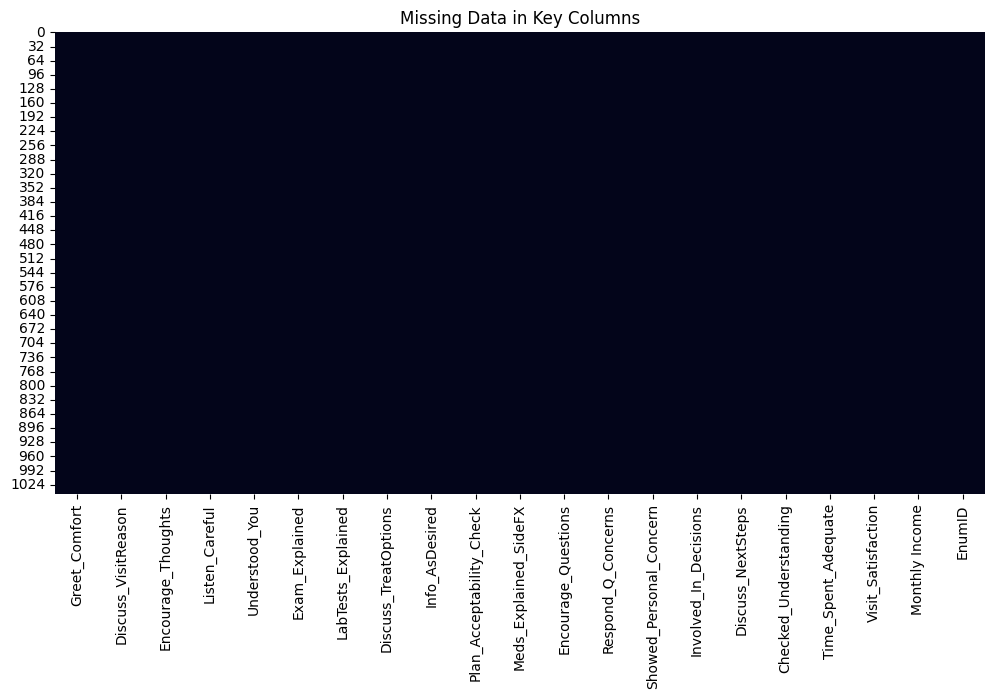

In [ ]:
#@title Missing Data Heatmap (if running in notebook/Colab)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df[likert_columns + ['Monthly Income', 'EnumID']].isnull(), cbar=False)
plt.title("Missing Data in Key Columns")
plt.show()

In [ ]:
# Save the clean data
df.to_csv(os.path.join(data_dir, "clean_data.csv"), index=False)

In [ ]:
df.head()

,EnumID,State,Age,Gender,Marital Status,Family Setting,Num of Children,Educational Status,Employment Status,Monthly Income,...,Monthly Income_zscore,HIV_Duration_Years_zscore,Care_Duration_Years_zscore,Facility_Care_Dur_Years_zscore,Age_log,Num of Children_log,Monthly Income_log,HIV_Duration_Years_log,Care_Duration_Years_log,Facility_Care_Dur_Years_log
0,SYNTH-NEU-284,Jigawa,29.5,Female,Married,Monogamy,1.5,"Tertiary education (e.g., University, college)",Self-employed,10000.0,...,0.753926,1.500846,0.990137,1.191044,3.417727,0.916291,9.210440,1.098612,2.602690,1.098612
1,BC023,Bauchi,29.5,Female,Widowed,Polygamy,5.0,No formal education,Self-employed,10000.0,...,0.753926,0.968636,1.803030,1.554119,3.417727,1.791759,9.210440,2.602690,0.405465,0.405465
2,SYNTH-SAT-140,Jigawa,65.0,Female,Widowed,Monogamy,1.5,Secondary education,Unemployed,75500.0,...,0.801418,1.500846,1.453884,0.503307,4.189655,0.916291,11.231901,1.098612,1.098612,2.302585
3,JG14,Jigawa,39.5,Female,Divorced,Monogamy,1.5,Secondary education,Employed part-time,10000.0,...,0.753926,0.968636,0.990137,1.350482,3.701302,0.916291,9.210440,2.602690,2.602690,2.602690
4,SYNTH-VER-519,Bauchi,39.5,Female,Single,Monogamy,5.0,Secondary education,Self-employed,10000.0,...,0.753926,0.145475,0.175463,0.503307,3.701302,1.791759,9.210440,2.302585,2.302585,2.302585


In [ ]:
df.columns

Index(['EnumID', 'State', 'Age', 'Gender', 'Marital Status', 'Family Setting',
       'Num of Children', 'Educational Status', 'Employment Status',
       'Monthly Income', 'Treatment Regimen', 'HIV_Duration_Years',
       'Care_Duration_Years', 'Facility_Care_Dur_Years', 'HIV_Diag_Type',
       'Greet_Comfort', 'Discuss_VisitReason', 'Encourage_Thoughts',
       'Listen_Careful', 'Understood_You', 'Exam_Explained',
       'LabTests_Explained', 'Discuss_TreatOptions', 'Info_AsDesired',
       'Plan_Acceptability_Check', 'Meds_Explained_SideFX',
       'Encourage_Questions', 'Respond_Q_Concerns', 'Showed_Personal_Concern',
       'Involved_In_Decisions', 'Discuss_NextSteps', 'Checked_Understanding',
       'Time_Spent_Adequate', 'Visit_Satisfaction', 'Source',
       'Monthly_Income_Missing', 'Age_zscore', 'Num of Children_zscore',
       'Monthly Income_zscore', 'HIV_Duration_Years_zscore',
       'Care_Duration_Years_zscore', 'Facility_Care_Dur_Years_zscore',
       'Age_log', 'Num of